In [1]:
!pip install d2l==0.17.2

In [2]:
import math
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l

In [3]:
max_degree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = np.zeros(max_degree)  # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [4]:
# Convert from NumPy ndarrays to tensors
true_w, features, poly_features, labels = [tf.constant(x, dtype=
    tf.float32) for x in [true_w, features, poly_features, labels]]

In [5]:
features[:2], poly_features[:2, :], labels[:2]

(<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[ 1.4354898 ],
        [-0.12277762]], dtype=float32)>,
 <tf.Tensor: shape=(2, 20), dtype=float32, numpy=
 array([[ 1.0000000e+00,  1.4354898e+00,  1.0303155e+00,  4.9300247e-01,
          1.7692502e-01,  5.0794810e-02,  1.2152572e-02,  2.4921277e-03,
          4.4717800e-04,  7.1324386e-05,  1.0238543e-05,  1.3361204e-06,
          1.5983227e-07,  1.7649045e-08,  1.8096447e-09,  1.7318177e-10,
          1.5537542e-11,  1.3119990e-12,  1.0463118e-13,  7.9051052e-15],
        [ 1.0000000e+00, -1.2277762e-01,  7.5371717e-03, -3.0846533e-04,
          9.4681591e-06, -2.3249561e-07,  4.7575428e-09, -8.3445681e-11,
          1.2806577e-12, -1.7470678e-14,  2.1450081e-16, -2.3941725e-18,
          2.4495900e-20, -2.3134986e-22,  2.0288990e-24, -1.6606892e-26,
          1.2743466e-28, -9.2036026e-31,  6.2777577e-33, -4.0566743e-35]],
       dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([5.9133596, 4.8208613], dtyp

In [6]:
def evaluate_loss(net, data_iter, loss):
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        l = loss(net(X), y)
        metric.add(tf.reduce_sum(l), d2l.size(l))
    return metric[0] / metric[1]

In [7]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = tf.losses.MeanSquaredError()
    input_shape = train_features.shape[-1]
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Dense(1, use_bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    test_iter = d2l.load_array((test_features, test_labels), batch_size,
                               is_train=False)
    trainer = tf.keras.optimizers.SGD(learning_rate=.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net.get_weights()[0].T)

weight: [[ 4.9627333  1.238008  -3.3649795  5.4884806]]


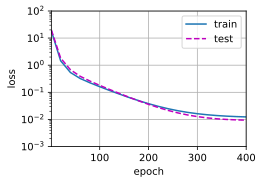

In [8]:
# Pick the first four dimensions, i.e., 1, x, x^2/2!, x^3/3! from the
# polynomial features
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.0868413 3.6645205]]


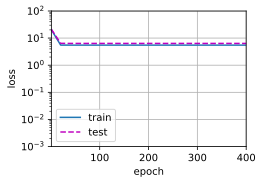

In [9]:
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.957366    1.2268533  -3.3159394   5.333631   -0.20373362  1.095761
  -0.15924183  0.6733462  -0.2065912   0.46033767 -0.07436758 -0.2840295
  -0.36860088  0.02213865 -0.42974013  0.28629583 -0.17380711 -0.1945053
   0.23204136  0.06699884]]


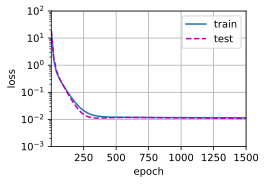

In [10]:
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)